In [1]:
import glob
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
from tqdm import tqdm

from src.test_utils import load_submission

InteractiveShell.ast_node_interactivity = "all"

In [2]:
root_dir = "/app/_data/artist_data/"
test_dir = "/app/_data/artist_data/test_features/"
test = pd.read_csv(os.path.join(root_dir, "test_meta.tsv"), sep="\t")
test["path"] = test["archive_features_path"].apply(
    lambda x: os.path.join(root_dir, "test_features", x)
)

top_size = 100

In [3]:
def save_submission(submission, submission_path, submission_name, top=100):
    with open(os.path.join(submission_path, submission_name), "w") as f:
        for query_trackid, result in submission.items():
            f.write("{}\t{}\n".format(query_trackid, " ".join(map(str, result[:top]))))

## Ensemble from submissions

In [4]:
submissions_paths = glob.glob("/app/_data/artist_data/models/*/*500.txt")
submissions_paths

['/app/_data/artist_data/models/fold_1/submission_500.txt',
 '/app/_data/artist_data/models/fold_3/submission_500.txt',
 '/app/_data/artist_data/models/fold_2/submission_500.txt',
 '/app/_data/artist_data/models/fold_5/submission_500.txt',
 '/app/_data/artist_data/models/fold_0/submission_500.txt']

In [5]:
submissions = []
for path in tqdm(submissions_paths):
    submissions.append(load_submission(input_path=path, max_top_size=top_size))

100% 5/5 [00:11<00:00,  2.38s/it]


In [6]:
n_sub = len(submissions_paths)
top_names = ["mean", "median"]
top_names.extend(
    [
        "top" + str(x)
        for x in range(len(submissions_paths) // 2 + 1, len(submissions_paths) + 1)
    ]
)
avg_submission = {x: {} for x in top_names}
avg_submission

{'mean': {}, 'median': {}, 'top3': {}, 'top4': {}, 'top5': {}}

In [7]:
for trackid in tqdm(test["trackid"].tolist()[:100]):
    track_ranks = {}
    all_tracks = np.zeros([n_sub, top_size])
    for i in range(len(submissions)):
        all_tracks[i] = submissions[i][trackid]
    values, counts = np.unique(
        all_tracks,
        return_index=False,
        return_inverse=False,
        return_counts=True,
    )
    values = values[counts >= (n_sub) // 2 + 1]
    df = pd.DataFrame()
    for v in range(values.shape[0]):
        rank = np.argwhere(all_tracks == values[v])[:, 1]
        sorted_rank = np.sort(rank)
        df.loc[v, "trackid"] = values[v]
        df.loc[v, "ids"] = " ".join(list(map(str, sorted_rank)))
        df.loc[v, "count"] = rank.shape[0]
        df.loc[v, "mean"] = rank.mean()
        df.loc[v, "median"] = sorted_rank[1:-1].mean()
        for name in top_names[2:]:
            n_lim = int(name[3:])
            df.loc[v, name] = sorted_rank[:n_lim].mean()

    df["trackid"] = df["trackid"].astype("int")

    avg_submission["mean"][trackid] = (
        df.sort_values(by=["mean", "median"]).head(100)["trackid"].tolist()
    )
    for name in top_names[1:]:
        avg_submission[name][trackid] = (
            df.sort_values(by=[name, "mean"]).head(100)["trackid"].tolist()
        )

100% 100/100 [00:08<00:00, 11.41it/s]


In [8]:
os.makedirs("/app/_data/artist_data/ens_submissions/", exist_ok=True)
for name in top_names:
    save_submission(
        avg_submission[name],
        "/app/_data/artist_data/ens_submissions/",
        f"{name}_submission.txt",
    )

In [9]:
df.head(10)

,trackid,ids,count,mean,median,top3,top4,top5
0,167258,17 71 87,3.0,58.333333,71.000000,58.333333,58.333333,58.333333
1,167450,4 6 13 30 36,5.0,17.800000,16.333333,7.666667,13.250000,17.800000
2,167783,3 43 54 65,4.0,41.250000,48.500000,33.333333,41.250000,41.250000
3,168895,35 37 50 65,4.0,46.750000,43.500000,40.666667,46.750000,46.750000
4,169290,1 17 39 97,4.0,38.500000,28.000000,19.000000,38.500000,38.500000
5,169911,0 0 1 2 4,5.0,1.400000,1.000000,0.333333,0.750000,1.400000
6,169969,2 3 4 7 79,5.0,19.000000,4.666667,3.000000,4.000000,19.000000
7,172221,19 36 73,3.0,42.666667,36.000000,42.666667,42.666667,42.666667
8,172260,6 10 11 20 48,5.0,19.000000,13.666667,9.000000,11.750000,19.000000
9,172371,1 33 47 88,4.0,42.250000,40.000000,27.000000,42.250000,42.250000


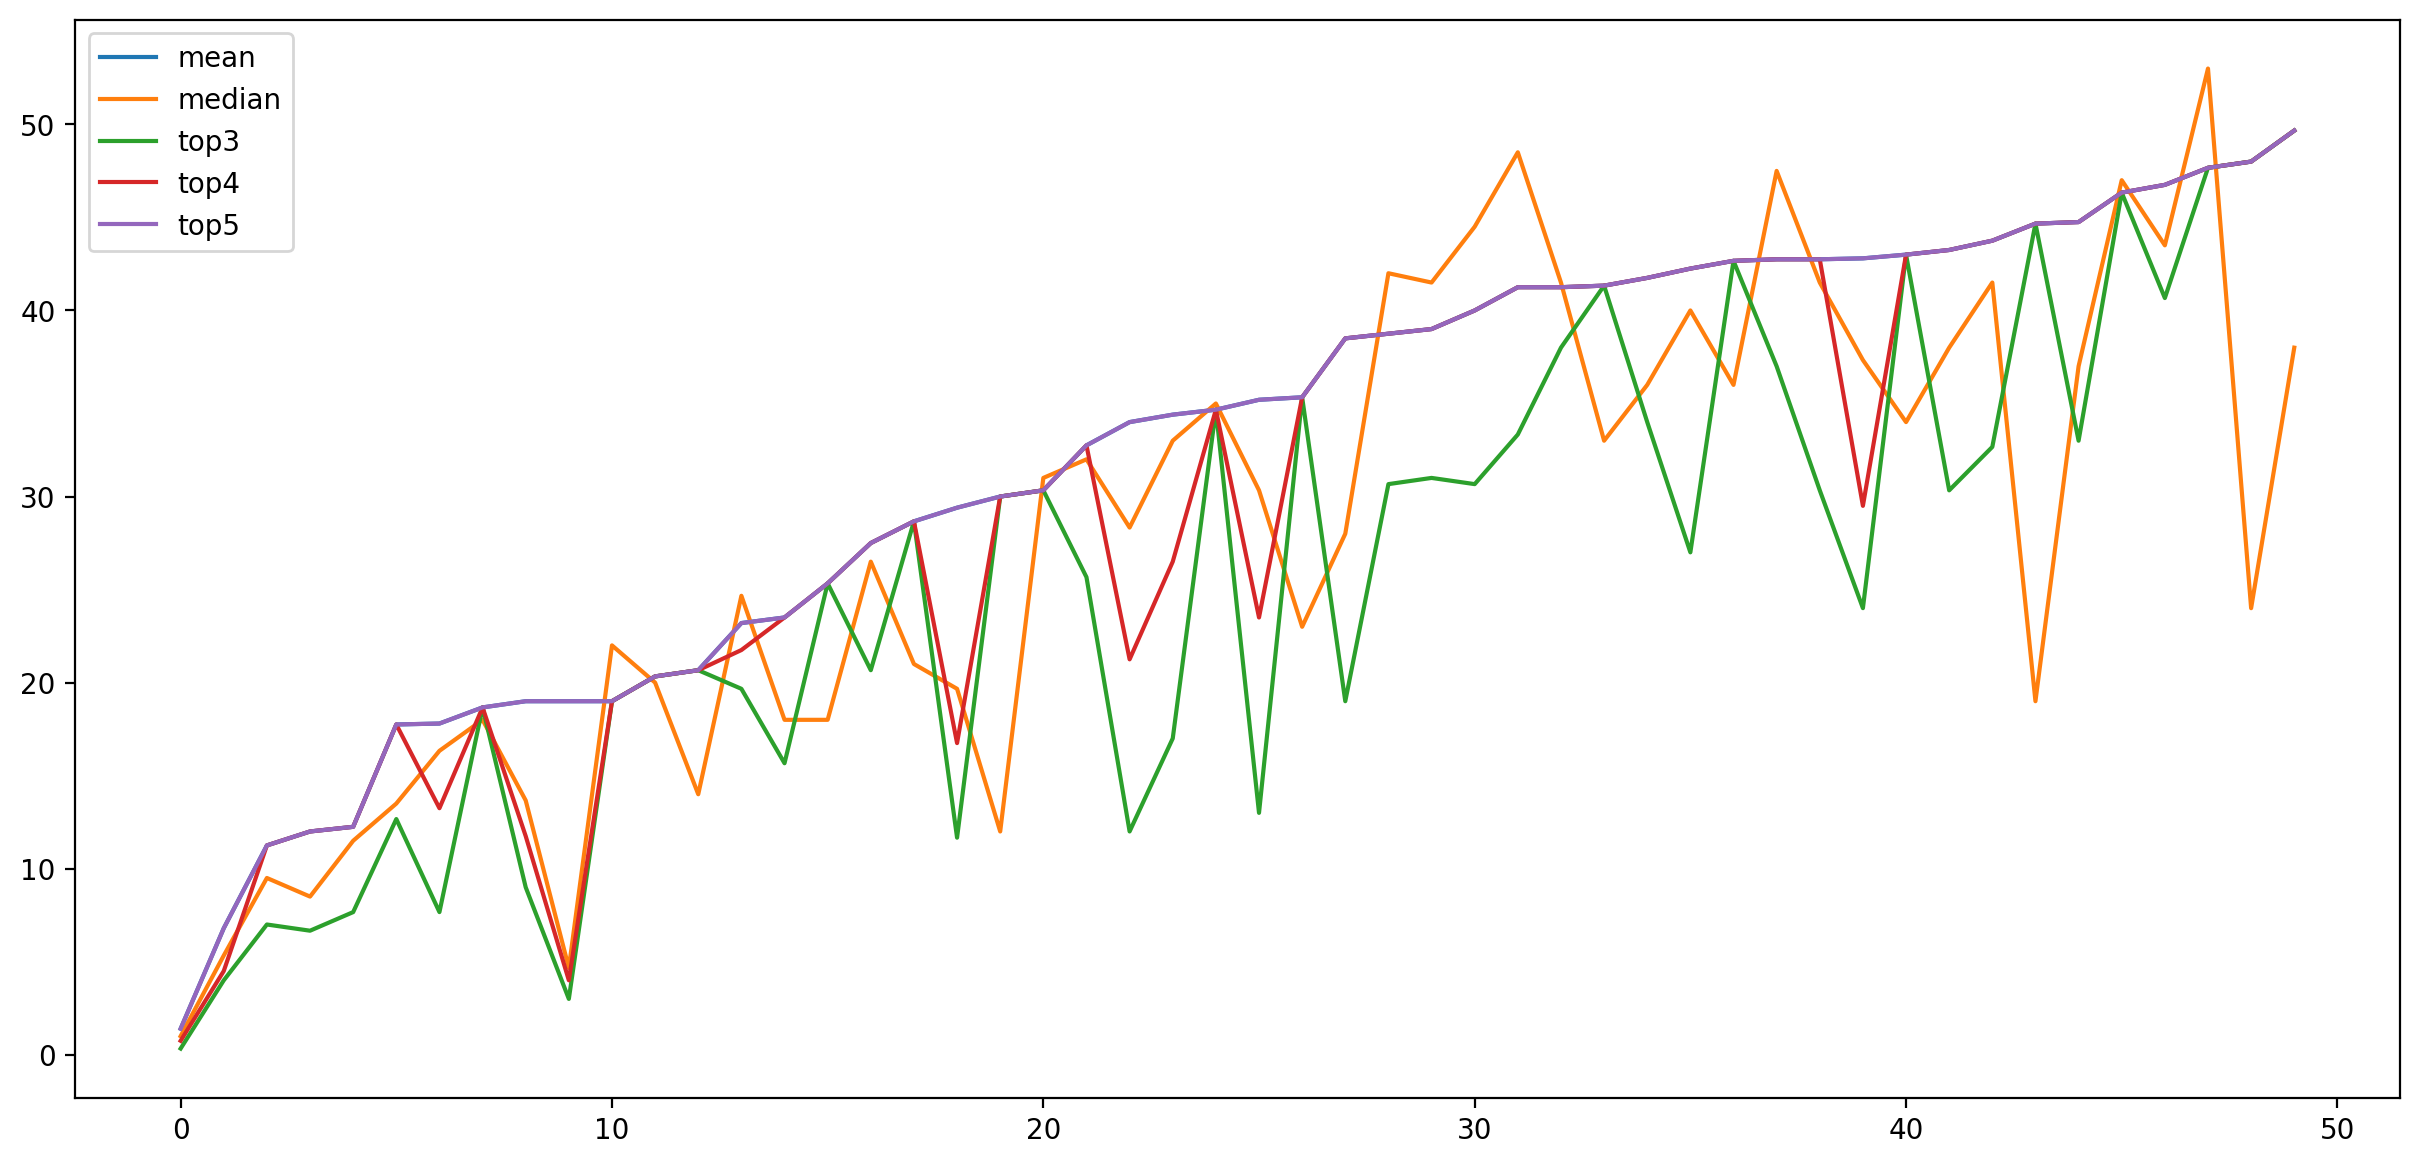

In [10]:
df[top_names].sort_values("mean").reset_index(drop=True).head(50).plot(figsize=(15, 7))
plt.show();

## For 8 folds

In [11]:
avg_submission = {
    "top4": {},
    "top5": {},
    "top6": {},
    "top7": {},
    "top8": {},
    "mean": {},
    "mid": {},
}

In [6]:
for trackid in tqdm(test["trackid"].tolist()):
    track_ranks = {}

    all_tracks = np.zeros([8, top_size])
    for i in range(len(submissions)):
        all_tracks[i] = submissions[i][trackid]
    values, counts = np.unique(
        all_tracks,
        return_index=False,
        return_inverse=False,
        return_counts=True,
    )
    values = values[counts >= 4]
    names = ["trackid", "count", "mean", "top4", "top5", "top6", "top7", "top8", "mid"]
    arr = np.zeros([values.shape[0], len(names)])
    for v in range(values.shape[0]):
        rank = np.argwhere(all_tracks == values[v])[:, 1]
        arr[v, 0] = values[v]  # trackid
        arr[v, 1] = rank.shape[0]  # count
        arr[v, 2] = rank.mean()  # mean
        arr[v, 3] = np.sort(rank)[:4].mean()  # top4
        arr[v, 4] = np.sort(rank)[:5].mean()  # top5
        arr[v, 5] = np.sort(rank)[:6].mean()  # top6
        arr[v, 6] = np.sort(rank)[:7].mean()  # top7
        arr[v, 7] = np.sort(rank)[:8].mean()  # top8
        arr[v, 8] = np.sort(rank)[1:-1].mean()  # mid

    avg_submission["top4"][trackid] = arr[
        np.lexsort((arr[:, names.index("mid")], arr[:, names.index("top4")]))
    ][:, 0][:100].astype("int")
    avg_submission["top5"][trackid] = arr[
        np.lexsort((arr[:, names.index("mid")], arr[:, names.index("top5")]))
    ][:, 0][:100].astype("int")
    avg_submission["top6"][trackid] = arr[
        np.lexsort((arr[:, names.index("mid")], arr[:, names.index("top6")]))
    ][:, 0][:100].astype("int")
    avg_submission["top7"][trackid] = arr[
        np.lexsort((arr[:, names.index("mid")], arr[:, names.index("top7")]))
    ][:, 0][:100].astype("int")
    avg_submission["top8"][trackid] = arr[
        np.lexsort((arr[:, names.index("mid")], arr[:, names.index("top8")]))
    ][:, 0][:100].astype("int")
    avg_submission["mean"][trackid] = arr[
        np.lexsort((arr[:, names.index("mid")], arr[:, names.index("mean")]))
    ][:, 0][:100].astype("int")
    avg_submission["mid"][trackid] = arr[
        np.lexsort((arr[:, names.index("top6")], arr[:, names.index("mid")]))
    ][:, 0][:100].astype("int")

100% 41377/41377 [37:53<00:00, 18.20it/s]


In [8]:
for n in ["mean", "top4", "top5", "top6", "top7", "top8", "mid"]:
    save_submission(
        avg_submission[n], "/app/_data/artist_data/ens_submissions/", f"{n}_final.txt"
    )